# LIBRARY

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk import tokenize
import re
nltk.download('stopwords')
import csv
from openpyxl import Workbook
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib
import matplotlib.pyplot as plt
import networkx as nx
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.util import ngrams
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
!pip install wordcloud
!pip install -U nltk
!pip install rake-nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hkhiy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Data

In [62]:
df=pd.read_excel(r'C:\Users\hkhiy\Documents\NCKH_Airbnb\Data1.xlsx')
df.info

<bound method DataFrame.info of        reviewer_name                reviewer_country rental_date  \
0                Huệ                       Việt Nam  2023-03-02   
1               Đình                       Việt Nam  2023-03-18   
2               Ngọc                       Việt Nam  2023-08-01   
3              Tuyết                       Việt Nam  2023-09-06   
4               Hùng                       Việt Nam  2023-01-16   
...              ...                             ...         ...   
101562        Nguyễn  Thành phố Hồ Chí Minh, Vietnam  2023-11-15   
101563         Barry           Sierra Vista, Arizona  2023-11-14   
101564          Loan                 Hà Nội, Vietnam  2023-11-14   
101565      Novaroon                           Ấn Độ  2023-11-12   
101566         Kevin              New York, New York  2023-11-12   

                                                 comments  
0                                          The good place  
1                              

# Clean Data

In [63]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

stopwords_list = set(stopwords.words('english'))
class TextPreprocess():

    def __init__(self):
        pass
        
    def preprocess_text(self,sen):
        if pd.isna(sen):
            return ""
        sen = str(sen).lower()

        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) 

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        # Remove lỗi font
        sentence =  re.sub("[^\x00-\x7F]", " ", sentence)
        
        return sentence





In [64]:
df = df.dropna(subset=['comments'])
df.info

<bound method DataFrame.info of        reviewer_name                reviewer_country rental_date  \
0                Huệ                       Việt Nam  2023-03-02   
1               Đình                       Việt Nam  2023-03-18   
2               Ngọc                       Việt Nam  2023-08-01   
3              Tuyết                       Việt Nam  2023-09-06   
4               Hùng                       Việt Nam  2023-01-16   
...              ...                             ...         ...   
101562        Nguyễn  Thành phố Hồ Chí Minh, Vietnam  2023-11-15   
101563         Barry           Sierra Vista, Arizona  2023-11-14   
101564          Loan                 Hà Nội, Vietnam  2023-11-14   
101565      Novaroon                           Ấn Độ  2023-11-12   
101566         Kevin              New York, New York  2023-11-12   

                                                 comments  
0                                          The good place  
1                              

In [65]:
date = df.groupby('rental_date').count()
date.head()

,reviewer_name,reviewer_country,comments
rental_date,,,
2019-01-01,123,123,123
2019-01-02,119,118,119
2019-01-03,89,88,89
2019-01-04,67,67,67
2019-01-05,80,80,80


In [66]:
df['rental_date'] = pd.to_datetime(df['rental_date'], format='mixed')
# Extract year from 'rental_date' and count occurrences of each year
year_counts = df['rental_date'].dt.year.value_counts()

df_new = pd.DataFrame(year_counts).reset_index()
df_new.columns = ['rental_date', 'count']
print(df_new)

   rental_date  count
0         2023  36671
1         2022  26392
2         2019  17551
3         2020  13531
4         2021   6472


C:\Users\hkhiy\AppData\Local\Temp\ipykernel_19956\828852446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rental_date'] = pd.to_datetime(df['rental_date'], format='mixed')


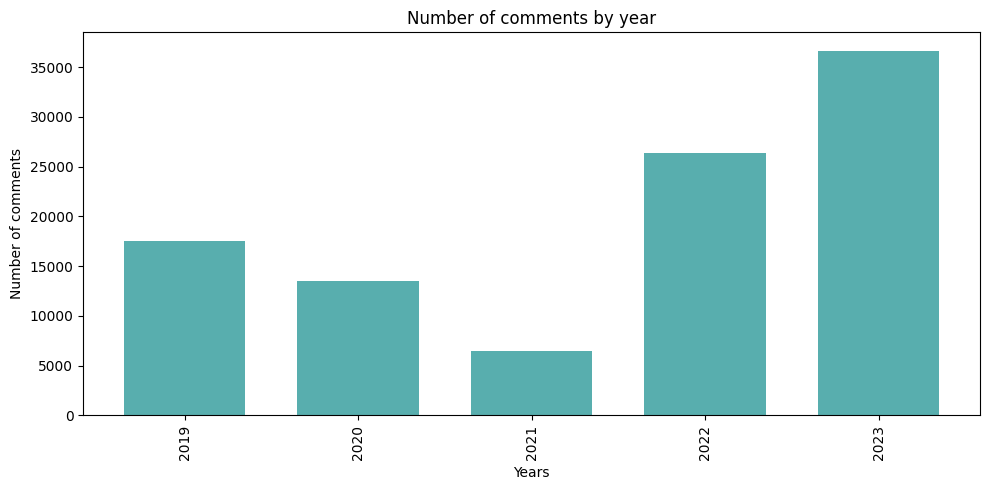

In [67]:
# creating the dataset
courses = list(df_new['rental_date'])
values = list(df_new['count'])

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color='#58AEAE', width=0.7)

plt.xlabel("Years")
plt.ylabel("Number of comments")
plt.title("Number of comments by year")
plt.xticks(courses, rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [68]:
test=TextPreprocess()
X = []
sentences= list(df['comments'])
for sen in sentences:
    X.append(test.preprocess_text(sen))

In [69]:
X[0]


'good place'

In [70]:
df['comments'] = X
df.count()

C:\Users\hkhiy\AppData\Local\Temp\ipykernel_19956\1428567899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['comments'] = X


reviewer_name       100616
reviewer_country    100428
rental_date         100617
comments            100617
dtype: int64

# Save After Preprocess Data

In [71]:
df.to_csv(r'C:\Users\hkhiy\Documents\NCKH_Airbnb\after_preprocess.csv', encoding='utf-8')

# SVM (Support Vector Machine)

# Labeled Data

In [72]:
def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    return lines

def label_sentiment(comment, positive_words, negative_words):
    if isinstance(comment, str) and comment.strip():  # Kiểm tra nếu comment là một chuỗi không rỗng
        # Chuyển đổi comment thành lowercase để so sánh dễ dàng hơn
        comment_lower = comment.lower()

        # Tách từ trong comment
        words = comment_lower.split()

        # Đếm số lần xuất hiện của các từ tích cực và tiêu cực
        num_positive_words = sum(1 for word in words if word in positive_words)
        num_negative_words = sum(1 for word in words if word in negative_words)

        # Gán nhãn dựa trên số từ tích cực và tiêu cực
        if num_positive_words > num_negative_words:
            return 'positive'
        elif num_positive_words < num_negative_words:
            return 'negative'
        else:
            return 'neutral'  # Nếu số lượng từ tích cực và tiêu cực bằng nhau, gán nhãn là neutral
    else:
        return 'neutral'  # Gán nhãn là neutral cho các comment rỗng hoặc không hợp lệ

# Đọc nội dung từ file positive và negative
positive_words = read_text_file('positive-words.txt')
negative_words = read_text_file('negative-words.txt')

# Xóa ký tự xuống dòng ('\n') ở cuối mỗi từ trong danh sách
positive_words = [word.strip() for word in positive_words]
negative_words = [word.strip() for word in negative_words]

# Đọc dữ liệu từ file CSV
data = pd.read_csv('after_preprocess.csv')

# Gán nhãn sentiment cho mỗi comment trong cột 'comments'
data['sentiment'] = data['comments'].apply(lambda x: label_sentiment(x, positive_words, negative_words))

#Gan positive =1, negative=2, neutral=0
X=[]
for label in data['sentiment']:
    if label=="positive":
        X.append(1)
    if label=="negative":
        X.append(2)
    if label=="neutral":
        X.append(0)

data['label']=X

# In ra số lượng mẫu cho mỗi nhãn
print(" positive:", len(data[data['sentiment'] == 'positive']))
print(" negative:", len(data[data['sentiment'] == 'negative']))
print(" neutral:", len(data[data['sentiment'] == 'neutral']))


 positive: 77557
 negative: 7385
 neutral: 15675


In [73]:
data

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Huệ,Việt Nam,2023-03-02,good place,positive,1
1,1,Đình,Việt Nam,2023-03-18,wind noisy,negative,2
2,2,Ngọc,Việt Nam,2023-08-01,good service staff contact nearly clock,positive,1
3,3,Tuyết,Việt Nam,2023-09-06,location near sea beautiful clean rooms,positive,1
4,4,Hùng,Việt Nam,2023-01-16,nice room clean wide friendly friendly friendly,positive,1
...,...,...,...,...,...,...,...
100612,101562,Nguyễn,"Thành phố Hồ Chí Minh, Vietnam",2023-11-15,ok,positive,1
100613,101563,Barry,"Sierra Vista, Arizona",2023-11-14,nigel real life buoy checked airbnb think flig...,positive,1
100614,101564,Loan,"Hà Nội, Vietnam",2023-11-14,looks like photos locations super communicatio...,positive,1
100615,101565,Novaroon,Ấn Độ,2023-11-12,great location clean accommodation necessary a...,positive,1


In [74]:
data.dropna()

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Huệ,Việt Nam,2023-03-02,good place,positive,1
1,1,Đình,Việt Nam,2023-03-18,wind noisy,negative,2
2,2,Ngọc,Việt Nam,2023-08-01,good service staff contact nearly clock,positive,1
3,3,Tuyết,Việt Nam,2023-09-06,location near sea beautiful clean rooms,positive,1
4,4,Hùng,Việt Nam,2023-01-16,nice room clean wide friendly friendly friendly,positive,1
...,...,...,...,...,...,...,...
100612,101562,Nguyễn,"Thành phố Hồ Chí Minh, Vietnam",2023-11-15,ok,positive,1
100613,101563,Barry,"Sierra Vista, Arizona",2023-11-14,nigel real life buoy checked airbnb think flig...,positive,1
100614,101564,Loan,"Hà Nội, Vietnam",2023-11-14,looks like photos locations super communicatio...,positive,1
100615,101565,Novaroon,Ấn Độ,2023-11-12,great location clean accommodation necessary a...,positive,1


In [75]:
# Lưu dữ liệu đã gán nhãn vào file CSV mới
data.to_csv('labeled_data_final.csv', index=False)


# Train and Test

In [76]:
df_sentiment=pd.read_csv('labeled_data_final.csv')
df_sentiment.head()
df_sentiment.info

<bound method DataFrame.info of         Unnamed: 0 reviewer_name                reviewer_country rental_date  \
0                0           Huệ                       Việt Nam  2023-03-02   
1                1          Đình                       Việt Nam  2023-03-18   
2                2          Ngọc                       Việt Nam  2023-08-01   
3                3         Tuyết                       Việt Nam  2023-09-06   
4                4          Hùng                       Việt Nam  2023-01-16   
...            ...           ...                             ...         ...   
100612      101562        Nguyễn  Thành phố Hồ Chí Minh, Vietnam  2023-11-15   
100613      101563         Barry           Sierra Vista, Arizona  2023-11-14   
100614      101564          Loan                 Hà Nội, Vietnam  2023-11-14   
100615      101565      Novaroon                           Ấn Độ  2023-11-12   
100616      101566         Kevin              New York, New York  2023-11-12   

       

In [77]:
df_sentiment.dropna(subset=['comments'], inplace=True)
df_sentiment.info

<bound method DataFrame.info of         Unnamed: 0 reviewer_name                reviewer_country rental_date  \
0                0           Huệ                       Việt Nam  2023-03-02   
1                1          Đình                       Việt Nam  2023-03-18   
2                2          Ngọc                       Việt Nam  2023-08-01   
3                3         Tuyết                       Việt Nam  2023-09-06   
4                4          Hùng                       Việt Nam  2023-01-16   
...            ...           ...                             ...         ...   
100612      101562        Nguyễn  Thành phố Hồ Chí Minh, Vietnam  2023-11-15   
100613      101563         Barry           Sierra Vista, Arizona  2023-11-14   
100614      101564          Loan                 Hà Nội, Vietnam  2023-11-14   
100615      101565      Novaroon                           Ấn Độ  2023-11-12   
100616      101566         Kevin              New York, New York  2023-11-12   

       

In [78]:
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(df_sentiment['comments'], df_sentiment['label'], test_size = 0.2, random_state = 42)

In [79]:
# Tao dataframe cho train and test
df_train80 = pd.DataFrame()
df_train80['comments'] = train_X
df_train80['label'] = train_Y

df_test20 = pd.DataFrame()
df_test20['comments'] = test_X
df_test20['label'] = test_Y


In [80]:
df_train80

,comments,label
93703,room hot water,1
77821,clean safe,1
38443,near center,0
9729,spacious airy room,1
79750,unable use mosquito air conditioning,2
...,...,...
6298,friendly mastery clean room,1
55104,room like picture space isolated homeowners co...,1
77098,rooms clean comfortable good service,1
865,clean,1


In [81]:
df_test20

,comments,label
14780,changed days arrived hotel told us costed usd...,2
69440,receptionist enthusiastic cute attentive guest...,1
86722,quiet clean close nature,1
17885,location quite convenient close lake night mar...,1
32569,sach,0
...,...,...
25751,room full facilities reasonable later come back,1
35980,good,1
30820,zones construction noisy,2
63388,room quite large bright soundproof,1


In [82]:
df_train80.to_csv('df_train80.csv')
df_test20.to_csv('df_test20.csv')

In [83]:
tfidf_vect_8020 = TfidfVectorizer()
tfidf_vect_8020.fit(df_sentiment['comments'])

# bieu dien vector TF-IDF cua data train & test
train_X_tfidf_8020 = tfidf_vect_8020.transform(df_train80['comments'])
test_X_tfidf_8020 = tfidf_vect_8020.transform(df_test20['comments'])

In [84]:
print(train_X_tfidf_8020)
#print(test_X_tfidf_8020)

  (0, 14907)	0.6273547660568077
  (0, 11334)	0.30846360574767945
  (0, 6321)	0.7150358043027973
  (1, 11466)	0.9481166517741281
  (1, 2347)	0.3179226551043772
  (2, 8715)	0.6656291571106773
  (2, 2017)	0.7462826711133853
  (3, 12500)	0.6395680181259918
  (3, 11334)	0.34258625097968387
  (3, 301)	0.6881768746696418
  (4, 14415)	0.38545569253036266
  (4, 14156)	0.5503916712012811
  (4, 8522)	0.49783904592046535
  (4, 2722)	0.4363162929583893
  (4, 278)	0.3320802526863791
  (5, 14890)	0.23544035852873485
  (5, 12981)	0.2884118893999098
  (5, 11813)	0.542651036367855
  (5, 11563)	0.1730450674949791
  (5, 11334)	0.07985250906767158
  (5, 7896)	0.242508332746298
  (5, 7440)	0.2510395106738664
  (5, 7219)	0.2077774088729116
  (5, 6311)	0.19556684911136196
  (5, 6240)	0.19208832481730675
  :	:
  (80210, 637)	0.2774114629573216
  (80210, 341)	0.35057014230535893
  (80211, 11877)	0.4944721221877555
  (80211, 11341)	0.5484446826436272
  (80211, 5622)	0.40907256484685894
  (80211, 2564)	0.44996290

In [85]:
print(train_X_tfidf_8020.shape)
print(test_X_tfidf_8020.shape)

(80214, 15349)
(20054, 15349)


In [86]:
percent_kept = 0.2  

num_features = int(percent_kept * train_X_tfidf_8020.shape[1])
selector = SelectKBest(chi2, k=num_features)

train_X_tfidf_8020_selected = selector.fit_transform(train_X_tfidf_8020, train_Y)
test_X_tfidf_8020_selected = selector.transform(test_X_tfidf_8020)
     

print(train_X_tfidf_8020_selected.shape)
print(test_X_tfidf_8020_selected.shape)

(80214, 3069)
(20054, 3069)


# Feature Selection

In [87]:
percent_kept = 0.2  
num_features = int(percent_kept * train_X_tfidf_8020.shape[1])

selector = SelectKBest(chi2, k=num_features)

train_X_tfidf_8020_selected = selector.fit_transform(train_X_tfidf_8020, train_Y)
test_X_tfidf_8020_selected = selector.transform(test_X_tfidf_8020)

# Process

In [88]:
model = SVC(C=1, kernel='rbf', gamma="scale")
 
# fit --> train
model.fit(train_X_tfidf_8020_selected, train_Y)

SVC(C=1)

In [89]:
predictions_SVM_8020 = model.predict(test_X_tfidf_8020_selected)

test_prediction_8020 = pd.DataFrame()
test_prediction_8020['comments'] = test_X
test_prediction_8020['label'] = predictions_SVM_8020


SVM_accuracy_8020 = accuracy_score(predictions_SVM_8020, test_Y)*100

SVM_accuracy_8020 = round(SVM_accuracy_8020,1)
     
test_prediction_8020

,comments,label
14780,changed days arrived hotel told us costed usd...,2
69440,receptionist enthusiastic cute attentive guest...,1
86722,quiet clean close nature,1
17885,location quite convenient close lake night mar...,1
32569,sach,0
...,...,...
25751,room full facilities reasonable later come back,1
35980,good,1
30820,zones construction noisy,2
63388,room quite large bright soundproof,1


In [90]:
# Luu du lieu test predict
test_prediction_8020.to_csv("test_prediction_8020_final.csv")

In [91]:
SVM_accuracy_8020

96.0

# Accuracy, Precision, Recall, f1-score

In [92]:
from sklearn.metrics import classification_report

print ("\nHere is the classification report:")
print (classification_report(test_Y, predictions_SVM_8020, zero_division='warn'))


Here is the classification report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3080
           1       0.99      0.98      0.99     15468
           2       0.88      0.85      0.86      1506

    accuracy                           0.96     20054
   macro avg       0.91      0.91      0.91     20054
weighted avg       0.96      0.96      0.96     20054



# Test Model

In [93]:
comments1 = "comfortable beautiful apartment"
comments1_vector = tfidf_vect_8020.transform([comments1])  # Vectorizing


model = SVC(C=1, kernel='rbf', gamma="scale")
model.fit(train_X_tfidf_8020, train_Y)

predicted_class = model.predict(comments1_vector)

if predicted_class == 1:
    print("positive")
else:
    print("negative")

positive


# Save trained model and vector

In [94]:
joblib.dump(model, "model.pkl")
joblib.dump(tfidf_vect_8020, "vectorizer.pkl")

['vectorizer.pkl']

In [95]:
chi = [0.1, 0.2, 0.3]
c = [0.1, 1, 10, 100]
kernel = ['rbf', 'poly']
gamma = [0.0001, 0.001, 0.1, 1, 'scale', 'auto']

def mulai(h, i, j, k):
    percent_kept = h
    num_features = int(percent_kept * train_X_tfidf_8020.shape[1])
    selector = SelectKBest(chi2, k=num_features)
    train_X_tfidf_8020_selected = selector.fit_transform(train_X_tfidf_8020, train_Y)
    test_X_tfidf_8020_selected = selector.transform(test_X_tfidf_8020)

    print(f"Chi Square = {h}\tParameter: c={i}, kernel={j}, gamma={k}")
    model = SVC(C=i, kernel=j, gamma=k)
    model.fit(train_X_tfidf_8020_selected, train_Y)

    predictions_SVM_8020 = model.predict(test_X_tfidf_8020_selected)
    test_prediction_8020 = pd.DataFrame()
    test_prediction_8020['comments'] = test_X
    test_prediction_8020['label'] = predictions_SVM_8020
    SVM_accuracy_8020 = accuracy_score(predictions_SVM_8020, test_Y) * 100
    SVM_accuracy_8020 = round(SVM_accuracy_8020, 1)

    print(f"Accuracy: {SVM_accuracy_8020}")
    print("Here is the classification report:")
    print(classification_report(test_Y, predictions_SVM_8020, zero_division=0.0), end="\n")
    print("============================================================")

    data.append({'Chi Square': h, 'C': i, 'Kernel': j, 'Gamma': k, 'Accuracy': SVM_accuracy_8020})

for h in chi:
  data = []
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
  for i in c:
    for j in kernel:
      for k in gamma:
        mulai(h, i, j, k)
  df = pd.DataFrame(data)

  # Sort the DataFrame by Accuracy in descending order
  df_sorted = df.sort_values('Accuracy', ascending=False)

  # Count the number of combinations with the same accuracy
  accuracy_counts = df_sorted['Accuracy'].value_counts().reset_index()
  accuracy_counts.columns = ['Accuracy', 'Count']
  accuracy_counts_sorted = accuracy_counts.sort_values('Accuracy', ascending=False)

  print("All Combinations:")
  print(df)
  print("\nWorst Combination:")
  print(df_sorted.tail(1))
  print("\nModerate Combination:")
  print(df_sorted.iloc[len(df_sorted) // 2])
  print("\nBest Combination:")
  print(df_sorted.head(1))
  print("\nAccuracy Counts:")
  print(accuracy_counts_sorted)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Chi Square = 0.1	Parameter: c=0.1, kernel=rbf, gamma=0.0001
Accuracy: 77.1
Here is the classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3080
           1       0.77      1.00      0.87     15468
           2       0.00      0.00      0.00      1506

    accuracy                           0.77     20054
   macro avg       0.26      0.33      0.29     20054
weighted avg       0.59      0.77      0.67     20054

Chi Square = 0.1	Parameter: c=0.1, kernel=rbf, gamma=0.001
Accuracy: 77.1
Here is the classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3080
           1       0.77      1.00      0.87     15468
           2       0.00      0.00      0.00      1506

    accuracy                           0.77     20054
   macro avg       0.26      0.3

# EDA

In [3]:
df_eda = pd.read_csv("labeled_data_final.csv", header = 0)
df_eda.head(5)

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Huệ,Việt Nam,2023-03-02,good place,positive,1
1,1,Đình,Việt Nam,2023-03-18,wind noisy,negative,2
2,2,Ngọc,Việt Nam,2023-08-01,good service staff contact nearly clock,positive,1
3,3,Tuyết,Việt Nam,2023-09-06,location near sea beautiful clean rooms,positive,1
4,4,Hùng,Việt Nam,2023-01-16,nice room clean wide friendly friendly friendly,positive,1


In [4]:
df_eda = df_eda.drop(['reviewer_name','reviewer_country'], axis = 1)
df_eda

,Unnamed: 0,rental_date,comments,sentiment,label
0,0,2023-03-02,good place,positive,1
1,1,2023-03-18,wind noisy,negative,2
2,2,2023-08-01,good service staff contact nearly clock,positive,1
3,3,2023-09-06,location near sea beautiful clean rooms,positive,1
4,4,2023-01-16,nice room clean wide friendly friendly friendly,positive,1
...,...,...,...,...,...
100612,101562,2023-11-15,ok,positive,1
100613,101563,2023-11-14,nigel real life buoy checked airbnb think flig...,positive,1
100614,101564,2023-11-14,looks like photos locations super communicatio...,positive,1
100615,101565,2023-11-12,great location clean accommodation necessary a...,positive,1


In [5]:
count = df_eda.groupby('sentiment').count()
print(count)

           Unnamed: 0  rental_date  comments  label
sentiment                                          
negative         7385         7385      7385   7385
neutral         15675        15675     15326  15675
positive        77557        77557     77557  77557


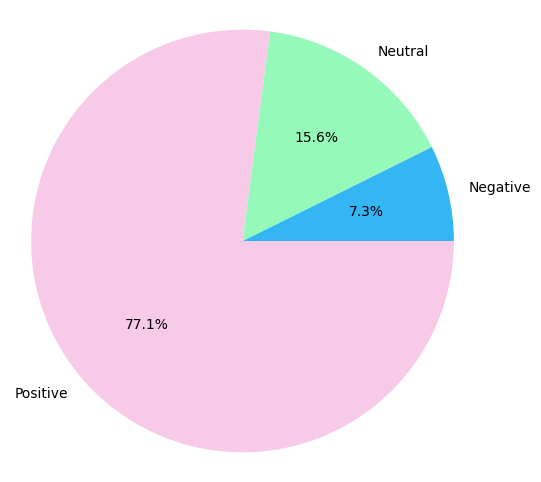

In [6]:
# Tạo DataFrame mẫu
data = {'sentiment': ['Negative', 'Neutral', 'Positive'],
        'comments': [7385, 15675, 77557]}
df1 = pd.DataFrame(data)

# Trích xuất dữ liệu từ DataFrame
sizes = df1['comments']
labels = df1['sentiment']
colors = ['#34b6f5', '#95fab9', '#f7cae7']
# Vẽ biểu đồ hình bánh
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.axis('equal')

# Hiển thị biểu đồ
plt.show()


# Co-ocurred of all comments

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
from matplotlib.patches import Rectangle

import pandas as pd
import statsmodels.api as sm

# import pyarrow.parquet as pq
# import pyarrow as pa


import os

import itertools
import collections

#---NLP packages--------------------
import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.util import ngrams

#----process string-------
import string
import re

#---network visualization-----------
import re
import networkx as nx


import warnings
warnings.filterwarnings("ignore")

In [8]:
def clean_text(sentence):
    sentence=str(sentence)
    sentence = re.sub("[%s]" % re.escape(string.punctuation), "", sentence.lower())
    sentence = re.sub("([^\x00-\x7F])+", " ", sentence)    
    sentence = sentence.replace('\n', ' ').replace('.', ' ').replace(',', ' ').replace('?', ' ')\
    .replace('\r', ' ').replace('!', ' ').replace('"\r', ' ').replace('"', ' ')\
    .replace("'", ' ').replace("''", ' ').replace('(', ' ').replace(')', ' ').replace(']', ' ')\
    .replace('-', ' ').replace('/', ' ')
    
    while ('  ' in sentence):
        sentence = sentence.replace('  ', ' ')
    return sentence

In [9]:
eng_stopwords = set(stopwords.words('english')) | {''}

In [10]:
def get_words(sentence, stopwords):
    words = set(sentence.split(' '))
    words = list(words-set(stopwords))
    if '' in words:
        words.remove('')   
    return list(words)

In [11]:
df_occured = pd.read_csv("labeled_data_final.csv")

In [12]:
txts = df_occured['comments'].values.tolist()
words_in_text = []
for txt in txts:
    txt = clean_text(txt)
    words_in_text.append(get_words(txt, eng_stopwords))

In [13]:
word_pairs = []
for words in words_in_text:
    words_ = list(set(words))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                word_pairs.append([word_i, word_j])
            else:
                word_pairs.append([word_i, word_j])


In [14]:
df_word_pairs = pd.DataFrame(data = word_pairs, columns=['word1', 'word2'])
word_pairs_count = df_word_pairs.groupby(['word1', 'word2']).size()
word_pairs_count = word_pairs_count.sort_values().tail(200).reset_index()

In [15]:
word_pairs_count.tail(10)

,word1,word2,0
190,friendly,enthusiastic,4566
191,clean,friendly,4813
192,friendly,room,4978
193,beautiful,room,5042
194,staff,room,7128
195,staff,friendly,7174
196,clean,enthusiastic,7738
197,staff,clean,8506
198,staff,enthusiastic,9996
199,clean,room,10822


# BIGRAM

In [16]:
# Create list of lists containing bigrams 
terms_bigram = [list(bigrams(words)) for words in words_in_text]

# View bigrams for the first assay
print('View bigrams for the first assay')
print(terms_bigram[0][:5])

# Flatten list of bigrams in clean text
bigram_list = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigram_list)

bigram_counts.most_common(5)

View bigrams for the first assay
[('good', 'place')]


[(('clean', 'friendly'), 4162),
 (('enthusiastic', 'room'), 4055),
 (('room', 'view'), 2312),
 (('staff', 'clean'), 2040),
 (('breakfast', 'delicious'), 2005)]

In [17]:
# Create list of lists containing bigrams 
terms_3gram = [list(ngrams(words, 3)) for words in words_in_text]

# View bigrams for the first assay
print('View N-grams (N=3) for the first assay')
print(terms_3gram[0][:5])


gram3_list = list(itertools.chain(*terms_3gram))

# Create counter of words in clean bigrams
gram3_counts = collections.Counter(gram3_list)

gram3_counts.most_common(5)

View N-grams (N=3) for the first assay
[]


[(('staff', 'clean', 'friendly'), 773),
 (('staff', 'clean', 'enthusiastic'), 432),
 (('clean', 'enthusiastic', 'room'), 416),
 (('beautiful', 'room', 'view'), 383),
 (('beautiful', 'enthusiastic', 'room'), 382)]

In [18]:
# Create network plot 
G = nx.Graph()
for _, row in word_pairs_count.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row[0])

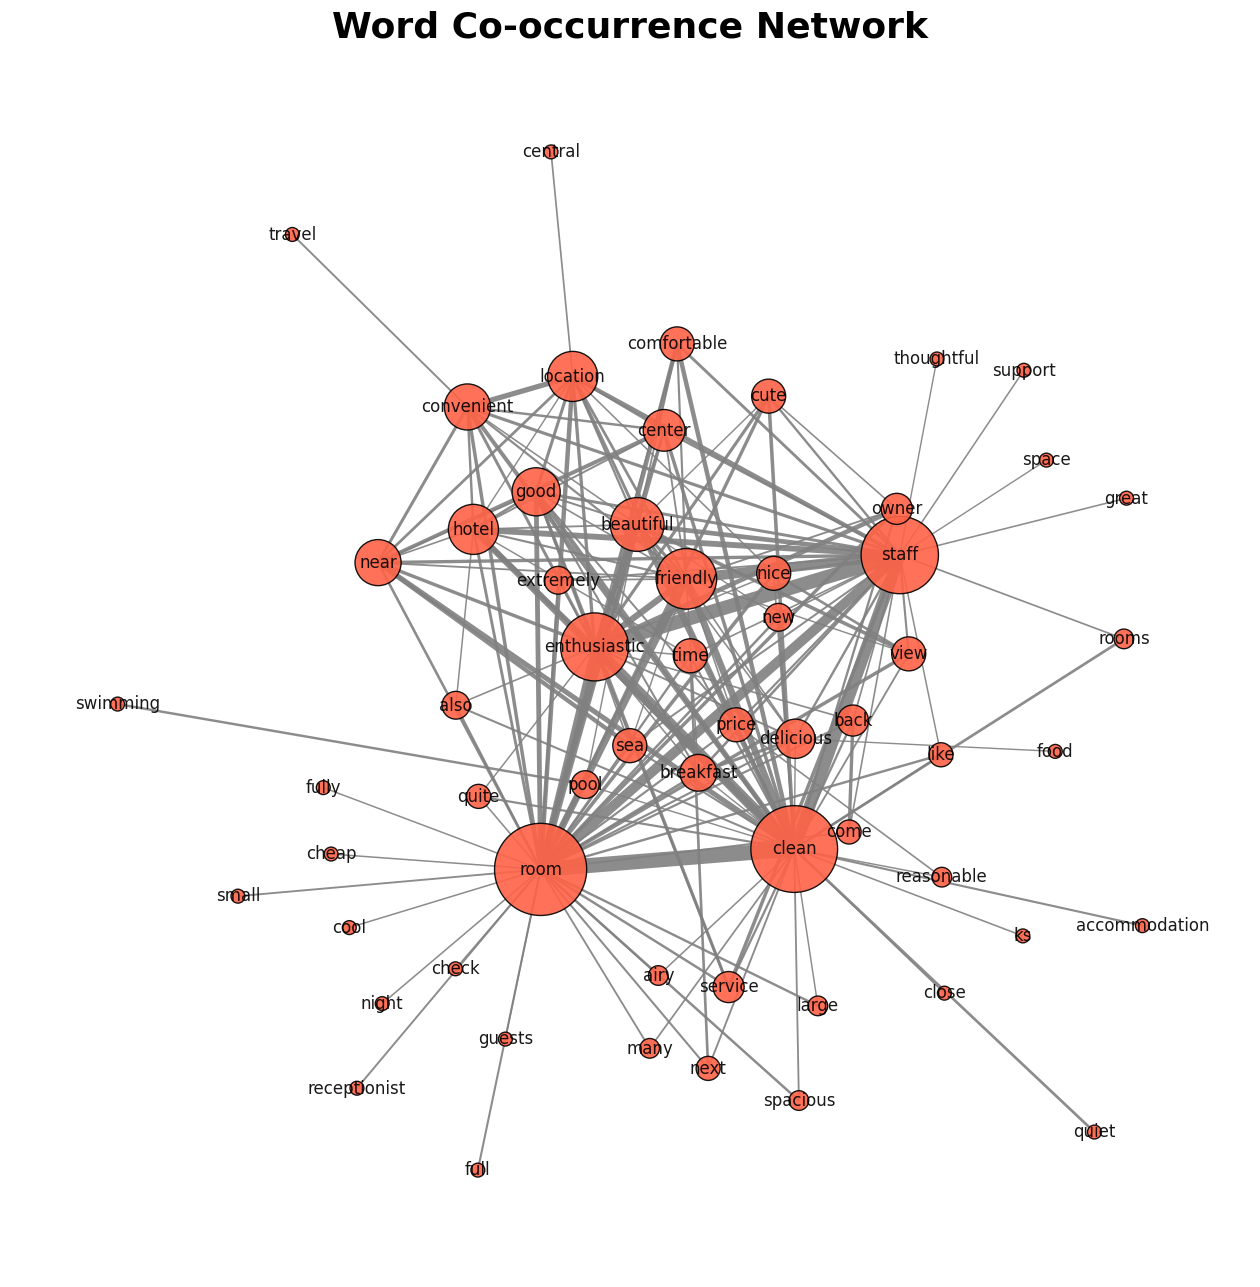

In [19]:
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]

nx.draw(G, pos_kkl, 
        with_labels=True, 
        node_size=[v * 100 for v in d.values()],
        nodelist=d.keys(),  
        width=weights, 
        edge_color='grey', 
        node_color='tomato', 
        alpha=0.9,
       )
#node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=10)
# Set title
ax.set_title('Word Co-occurrence Network', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'black', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

In [20]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for v in bigram_counts.most_common(30):
    G.add_edge(v[0][0], v[0][1], weight=(v[1] * 10))

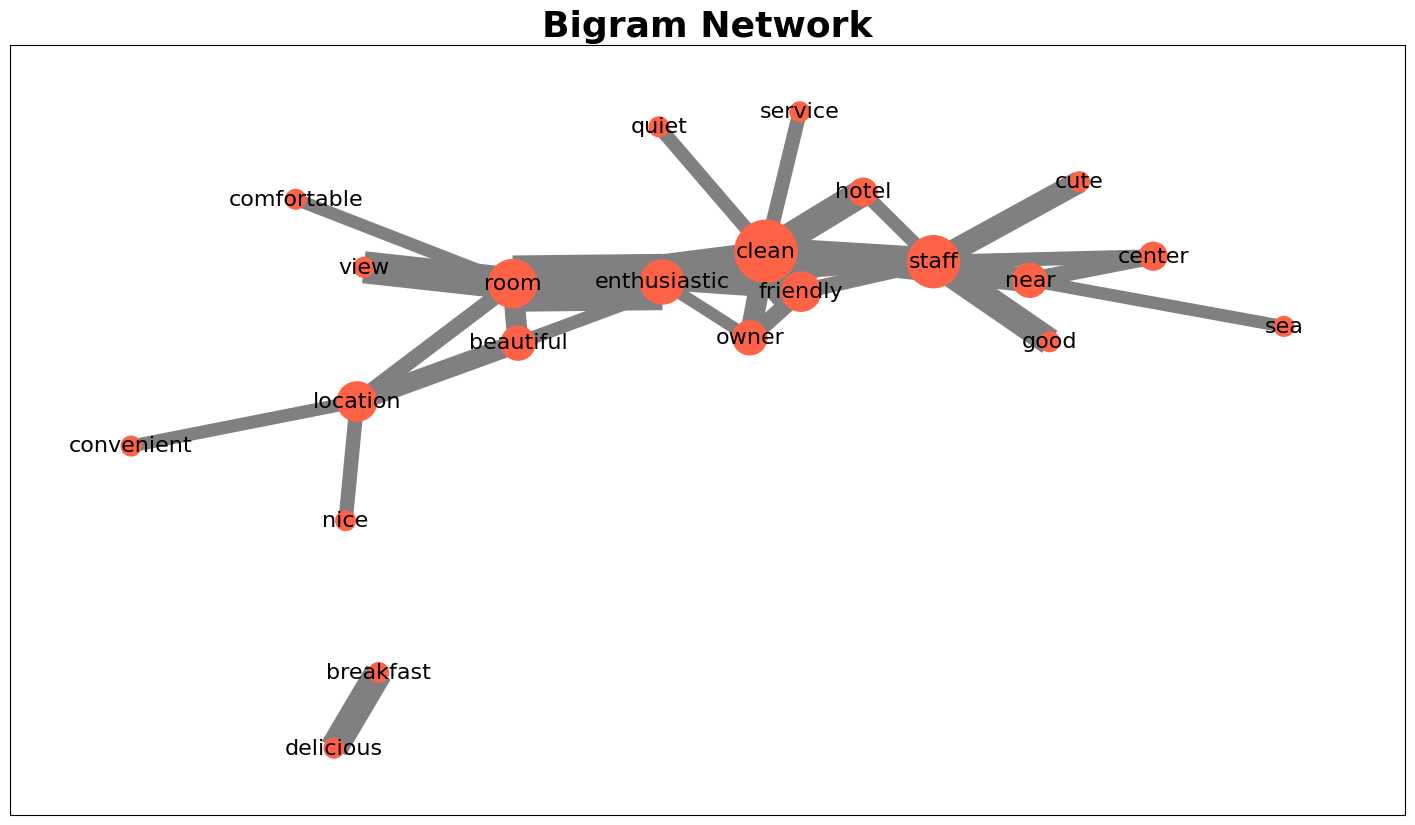

In [21]:
fig, ax = plt.subplots(figsize=(18, 10))

pos = nx.spring_layout(G, k=8)

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 node_size = [v * 200 for v in d.values()], 
                 edge_color='grey',
                 node_color='tomato',
                 with_labels = True,
                 ax=ax)

ax.set_title('Bigram Network', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'black', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')    
plt.show()

# Co-occured Positive

In [22]:
df_positive = df_occured[df_occured['sentiment'] == 'positive'].copy()
df_positive

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Huệ,Việt Nam,2023-03-02,good place,positive,1
2,2,Ngọc,Việt Nam,2023-08-01,good service staff contact nearly clock,positive,1
3,3,Tuyết,Việt Nam,2023-09-06,location near sea beautiful clean rooms,positive,1
4,4,Hùng,Việt Nam,2023-01-16,nice room clean wide friendly friendly friendly,positive,1
5,5,Song,Việt Nam,2023-02-09,ks near back beach room clean opportunity supp...,positive,1
...,...,...,...,...,...,...,...
100612,101562,Nguyễn,"Thành phố Hồ Chí Minh, Vietnam",2023-11-15,ok,positive,1
100613,101563,Barry,"Sierra Vista, Arizona",2023-11-14,nigel real life buoy checked airbnb think flig...,positive,1
100614,101564,Loan,"Hà Nội, Vietnam",2023-11-14,looks like photos locations super communicatio...,positive,1
100615,101565,Novaroon,Ấn Độ,2023-11-12,great location clean accommodation necessary a...,positive,1


In [23]:
txts_positive = df_positive['comments'].values.tolist()
words_in_text_positive = []
for txt in txts_positive:
    txt = clean_text(txt)
    words_in_text_positive.append(get_words(txt, eng_stopwords))

In [24]:
word_pairs_positive = []
for words in words_in_text_positive:
    words_ = list(set(words))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                word_pairs_positive.append([word_i, word_j])
            else:
                word_pairs_positive.append([word_i, word_j])

In [25]:
df_word_pairs_positive = pd.DataFrame(data = word_pairs_positive, columns=['word1', 'word2'])
word_pairs_count_positive = df_word_pairs_positive.groupby(['word1', 'word2']).size()
word_pairs_count_positive= word_pairs_count_positive.sort_values().tail(200).reset_index()

In [26]:
word_pairs_count_positive.tail(10)

,word1,word2,0
190,friendly,enthusiastic,4558
191,clean,friendly,4805
192,friendly,room,4918
193,beautiful,room,4974
194,staff,room,6677
195,staff,friendly,7094
196,clean,enthusiastic,7727
197,staff,clean,8444
198,staff,enthusiastic,9933
199,clean,room,10669


In [28]:
# Create list of lists containing bigrams 
terms_bigram = [list(bigrams(words)) for words in words_in_text_positive]

# View bigrams for the first assay
print('View bigrams for the first assay')
print(terms_bigram[0][:5])

# Flatten list of bigrams in clean text
bigram_list = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigram_list)

bigram_counts.most_common(5)

View bigrams for the first assay
[('good', 'place')]


[(('clean', 'friendly'), 4155),
 (('enthusiastic', 'room'), 4021),
 (('room', 'view'), 2174),
 (('staff', 'clean'), 2039),
 (('hotel', 'clean'), 1975)]

In [29]:
# Create list of lists containing bigrams 
terms_3gram = [list(ngrams(words, 3)) for words in words_in_text_positive]

# View bigrams for the first assay
print('View N-grams (N=3) for the first assay')
print(terms_3gram[0][:5])


gram3_list = list(itertools.chain(*terms_3gram))

# Create counter of words in clean bigrams
gram3_counts = collections.Counter(gram3_list)

gram3_counts.most_common(5)

View N-grams (N=3) for the first assay
[]


[(('staff', 'clean', 'friendly'), 773),
 (('staff', 'clean', 'enthusiastic'), 432),
 (('clean', 'enthusiastic', 'room'), 416),
 (('beautiful', 'enthusiastic', 'room'), 382),
 (('beautiful', 'room', 'view'), 380)]

In [30]:
# Create network plot 
G = nx.Graph()
for _, row in word_pairs_count_positive.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row[0])

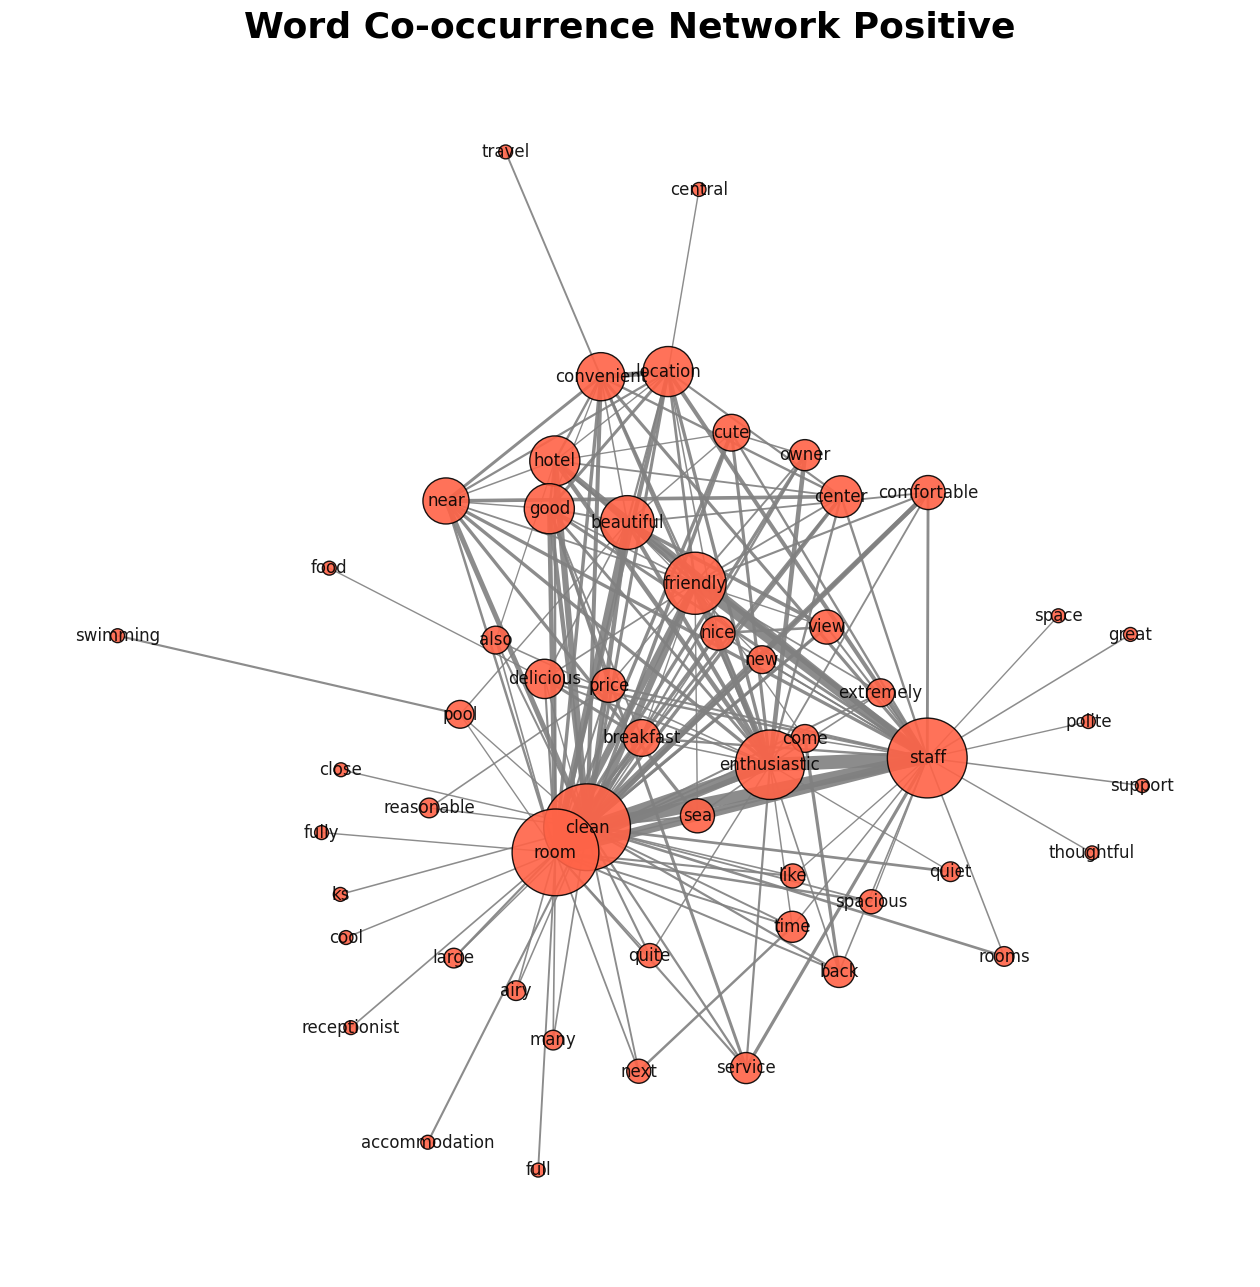

In [31]:
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]

nx.draw(G, pos_kkl, 
        with_labels=True, 
        node_size=[v * 100 for v in d.values()],
        nodelist=d.keys(),  
        width=weights, 
        edge_color='grey', 
        node_color='tomato', 
        alpha=0.9,
       )
#node_labels = nx.draw_networkx_labels(G, pos_kkl, labels, font_size=10)
# Set title
ax.set_title('Word Co-occurrence Network Positive', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'black', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

In [32]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for v in bigram_counts.most_common(30):
    G.add_edge(v[0][0], v[0][1], weight=(v[1] * 10))

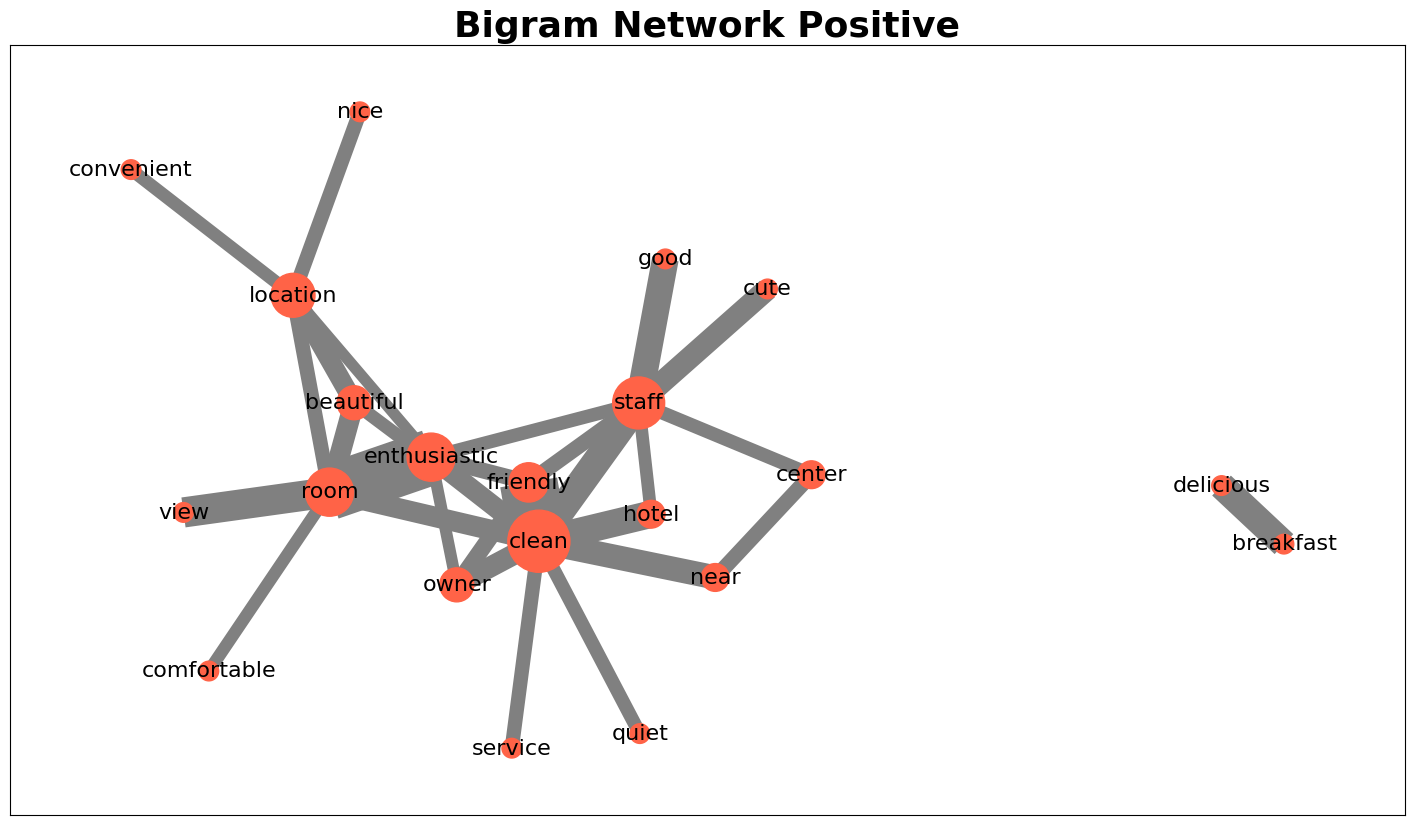

In [33]:
fig, ax = plt.subplots(figsize=(18, 10))

pos = nx.spring_layout(G, k=8)

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 node_size = [v * 200 for v in d.values()], 
                 edge_color='grey',
                 node_color='tomato',
                 with_labels = True,
                 ax=ax)

ax.set_title('Bigram Network Positive', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'black', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')    
plt.show()

# Co-occured Negative

In [34]:
df_negative = df_occured[df_occured['sentiment'] == 'negative'].copy()
df_negative

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
1,1,Đình,Việt Nam,2023-03-18,wind noisy,negative,2
42,42,Không tên,Việt Nam,2023-06-23,blanket soft thin small dirty towels dirty bl...,negative,2
55,55,Hạ,Việt Nam,2023-10-05,water room use downstairs heard whole night un...,negative,2
115,115,Thanh,Việt Nam,2023-07-21,done day without cleaning ask reason answer af...,negative,2
127,127,Vy,Việt Nam,2023-11-17,sophistication service gentle chronic way good...,negative,2
...,...,...,...,...,...,...,...
100359,101309,Lara,"Mannheim, Đức",2023-12-10,apartment really beautiful bright always conta...,negative,2
100366,101316,Linh,"Thành phố Hồ Chí Minh, Vietnam",2023-12-09,projector bit blurry expected checking problem...,negative,2
100372,101322,Anh,"Lilburn, Georgia",2023-12-09,neighborhood bit noisy,negative,2
100383,101333,Tham,"Victoria, Úc",2023-12-08,apartment everything need soon come back,negative,2


In [35]:
txts_negative = df_negative['comments'].values.tolist()
words_in_text_negative = []
for txt in txts_negative:
    txt = clean_text(txt)
    words_in_text_negative.append(get_words(txt, eng_stopwords))

In [36]:
word_pairs_negative = []
for words in words_in_text_negative:
    words_ = list(set(words))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                word_pairs_negative.append([word_i, word_j])
            else:
                word_pairs_negative.append([word_i, word_j])

In [37]:
df_word_pairs_negative = pd.DataFrame(data = word_pairs_negative, columns=['word1', 'word2'])
word_pairs_count_negative = df_word_pairs_negative.groupby(['word1', 'word2']).size()
word_pairs_count_negative = word_pairs_count_negative.sort_values().tail(200).reset_index()

In [38]:
word_pairs_count_negative.tail(5)

,word1,word2,0
195,smell,room,220
196,room,small,223
197,night,room,246
198,room,hotel,255
199,staff,room,266


In [39]:
# Create list of lists containing bigrams 
terms_bigram = [list(bigrams(words)) for words in words_in_text_negative]

# View bigrams for the first assay
print('View bigrams for the first assay')
print(terms_bigram[0][:5])

# Flatten list of bigrams in clean text
bigram_list = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigram_list)

bigram_counts.most_common(5)

View bigrams for the first assay
[('wind', 'noisy')]


[(('annoying', 'neighbors'), 89),
 (('room', 'check'), 78),
 (('breakfast', 'room'), 76),
 (('dirty', 'hotel'), 71),
 (('room', 'difficult'), 71)]

In [40]:
# Create list of lists containing bigrams 
terms_3gram = [list(ngrams(words, 3)) for words in words_in_text_negative]

# View bigrams for the first assay
print('View N-grams (N=3) for the first assay')
print(terms_3gram[0][:5])


gram3_list = list(itertools.chain(*terms_3gram))

# Create counter of words in clean bigrams
gram3_counts = collections.Counter(gram3_list)

gram3_counts.most_common(5)

View N-grams (N=3) for the first assay
[]


[(('lot', 'parking', 'crowded'), 61),
 (('room', 'compared', 'price'), 11),
 (('little', 'breakfast', 'dish'), 8),
 (('price', 'cheap', 'room'), 8),
 (('bit', 'bed', 'hard'), 7)]

In [41]:
# Create network plot 
G = nx.Graph()
for _, row in word_pairs_count_negative.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row[0])

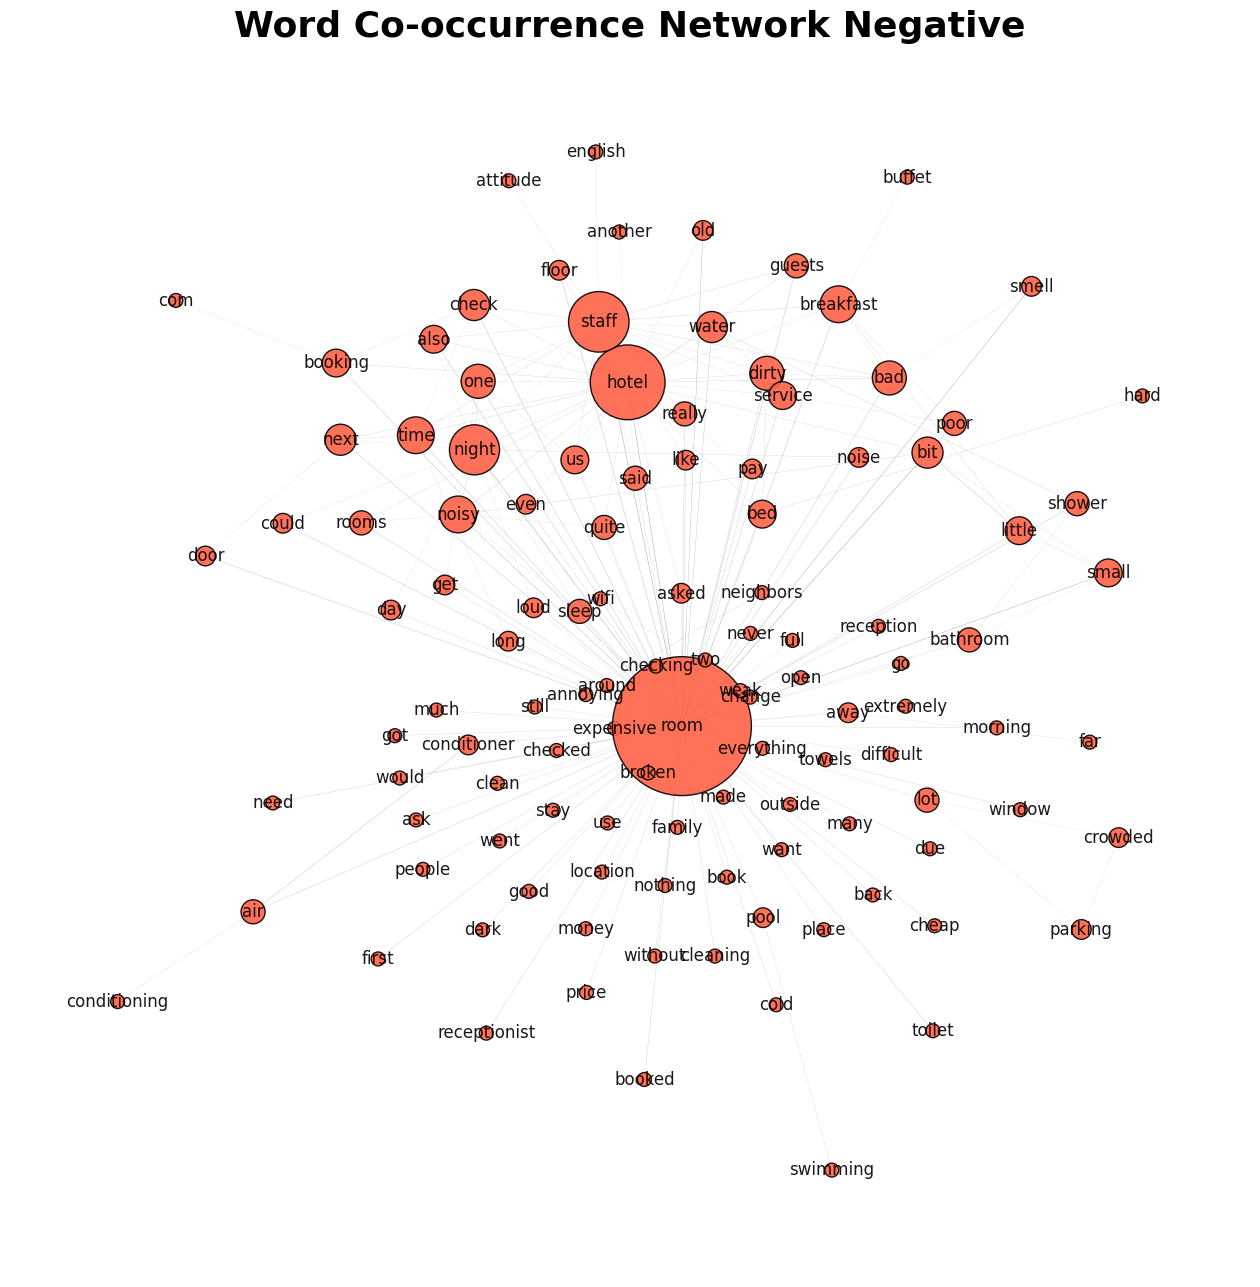

In [43]:
pos_kkl = nx.kamada_kawai_layout(G)
f, ax = plt.subplots(figsize=(16, 16))

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]

nx.draw(G, pos_kkl, 
        with_labels=True, 
        node_size=[v * 100 for v in d.values()],
        nodelist=d.keys(),  
        width=weights, 
        edge_color='grey', 
        node_color="tomato", 
        alpha=0.9,
       )
# Set title
ax.set_title('Word Co-occurrence Network Negative', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'black', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')
# Set edge color
plt.gca().collections[0].set_edgecolor("#000000")

In [44]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for v in bigram_counts.most_common(30):
    G.add_edge(v[0][0], v[0][1], weight=(v[1] * 10))

Text(0.5, 1.0, 'Bigram Network Negative')

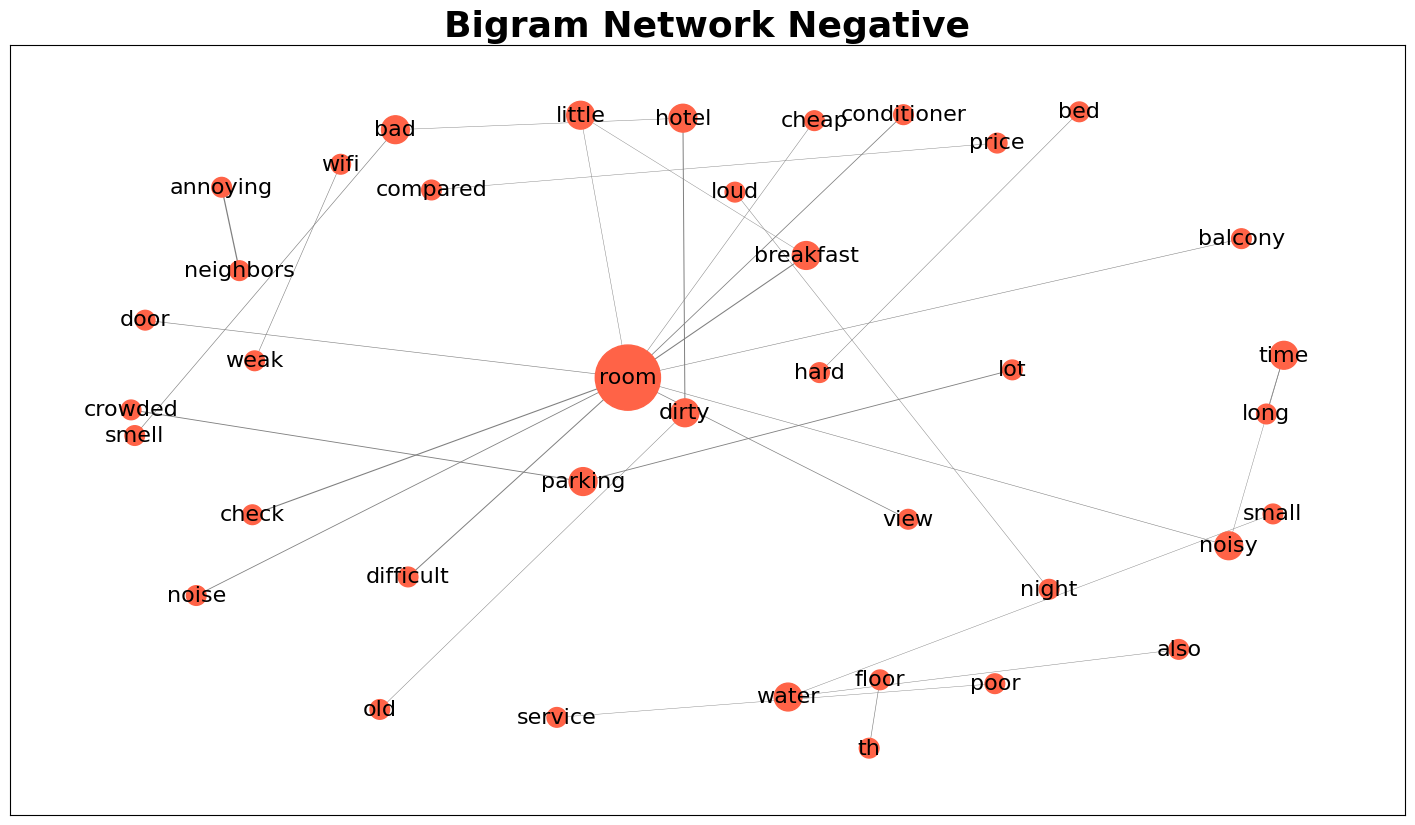

In [45]:
fig, ax = plt.subplots(figsize=(18, 10))

pos = nx.spring_layout(G, k=8)

d = dict(nx.degree(G))
edges = G.edges()
weights = [G[u][v]['weight']/1000 for u,v in edges]
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 node_size = [v * 200 for v in d.values()], 
                 edge_color='grey',
                 node_color='tomato',
                 with_labels = True,
                 ax=ax)

ax.set_title('Bigram Network Negative', 
             fontdict={'fontsize': 26,
            'fontweight': 'bold',
            'color': 'black', 
            'verticalalignment': 'baseline',
            'horizontalalignment': 'center'}, 
             loc='center')    

# WordCloud

In [46]:
df_wordcloud = pd.read_csv("labeled_data_final.csv", header=0)
df_wordcloud.head()

,Unnamed: 0,reviewer_name,reviewer_country,rental_date,comments,sentiment,label
0,0,Huệ,Việt Nam,2023-03-02,good place,positive,1
1,1,Đình,Việt Nam,2023-03-18,wind noisy,negative,2
2,2,Ngọc,Việt Nam,2023-08-01,good service staff contact nearly clock,positive,1
3,3,Tuyết,Việt Nam,2023-09-06,location near sea beautiful clean rooms,positive,1
4,4,Hùng,Việt Nam,2023-01-16,nice room clean wide friendly friendly friendly,positive,1


In [47]:
df_wordcloud = df_wordcloud.drop(['Unnamed: 0', 'reviewer_name', 'reviewer_country', 'rental_date'], axis = 1)
df_wordcloud.head()

,comments,sentiment,label
0,good place,positive,1
1,wind noisy,negative,2
2,good service staff contact nearly clock,positive,1
3,location near sea beautiful clean rooms,positive,1
4,nice room clean wide friendly friendly friendly,positive,1


In [48]:
?WordCloud

Init signature:
WordCloud(
    font_path=None,
    width=400,
    height=200,
    margin=2,
    ranks_only=None,
    prefer_horizontal=0.9,
    mask=None,
    scale=1,
    color_func=None,
    max_words=200,
    min_font_size=4,
    stopwords=None,
    random_state=None,
    background_color='black',
    max_font_size=None,
    font_step=1,
    mode='RGB',
    relative_scaling='auto',
    regexp=None,
    collocations=True,
    colormap=None,
    normalize_plurals=True,
    contour_width=0,
    contour_color='black',
    repeat=False,
    include_numbers=False,
    min_word_length=0,
    collocation_threshold=30,
)
Docstring:     
Word cloud object for generating and drawing.

Parameters
----------
font_path : string
    Font path to the font that will be used (OTF or TTF).
    Defaults to DroidSansMono path on a Linux machine. If you are on
    another OS or don't have this font, you need to adjust this path.

width : int (default=400)
    Width of the canvas.

height : int (default=2

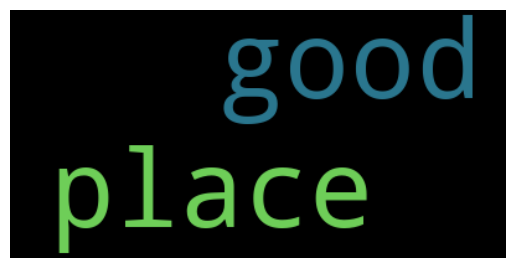

In [50]:
# Start with one review:
text = df_wordcloud.comments[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

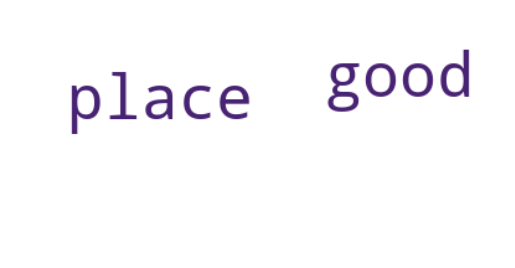

In [51]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
# Loại bỏ các giá trị không phải là chuỗi từ cột 'comments'
comments_str = [str(comment) for comment in df_wordcloud['comments'] if isinstance(comment, str)]

# Kết hợp các chuỗi lại với nhau
text = " ".join(comments_str)

# In số lượng từ trong chuỗi kết hợp
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 6509220 words in the combination of all reviews.


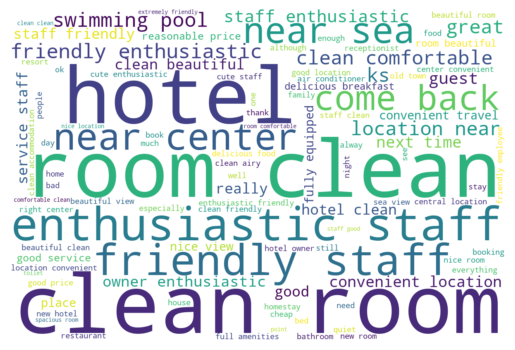

In [54]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords, max_words=100, background_color="white", colormap='viridis',).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
word_freq = wordcloud.words_

# Sắp xếp danh sách từ theo số lần xuất hiện
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# In ra những từ xuất hiện nhiều nhất
print("Top 10 words:")
words = []
frequency = []
for word, freq in sorted_word_freq[:30]:
    x=int(freq * len(text))
    print(f"{word}: {int(freq * len(text))}")
    words.append(word)  # Append word directly to the list
    frequency.append(x)  # Append freq directly to the list

Top 10 words:
clean room: 6509220
room clean: 6181090
hotel: 5996021
enthusiastic staff: 5117225
friendly staff: 4440530
near center: 3342603
near sea: 3095086
come back: 2790801
friendly enthusiastic: 2645470
swimming pool: 2500139
great: 2383194
ks: 2375246
location near: 2336643
clean comfortable: 2330966
staff enthusiastic: 2311664
guest: 2241269
next time: 2058471
convenient location: 1994889
owner enthusiastic: 1901786
really: 1835933
clean beautiful: 1820038
staff friendly: 1817767
good: 1783705
hotel clean: 1733748
service staff: 1703092
convenient travel: 1673572
place: 1645187
fully equipped: 1645187
nice view: 1637239
reasonable price: 1632698


In [56]:
print(words)
print(frequency)

['clean room', 'room clean', 'hotel', 'enthusiastic staff', 'friendly staff', 'near center', 'near sea', 'come back', 'friendly enthusiastic', 'swimming pool', 'great', 'ks', 'location near', 'clean comfortable', 'staff enthusiastic', 'guest', 'next time', 'convenient location', 'owner enthusiastic', 'really', 'clean beautiful', 'staff friendly', 'good', 'hotel clean', 'service staff', 'convenient travel', 'place', 'fully equipped', 'nice view', 'reasonable price']
[6509220, 6181090, 5996021, 5117225, 4440530, 3342603, 3095086, 2790801, 2645470, 2500139, 2383194, 2375246, 2336643, 2330966, 2311664, 2241269, 2058471, 1994889, 1901786, 1835933, 1820038, 1817767, 1783705, 1733748, 1703092, 1673572, 1645187, 1645187, 1637239, 1632698]


In [57]:
data_wordcloud = pd.DataFrame({'Word': words, 'Frequency': frequency})
data_wordcloud.head()

,Word,Frequency
0,clean room,6509220
1,room clean,6181090
2,hotel,5996021
3,enthusiastic staff,5117225
4,friendly staff,4440530


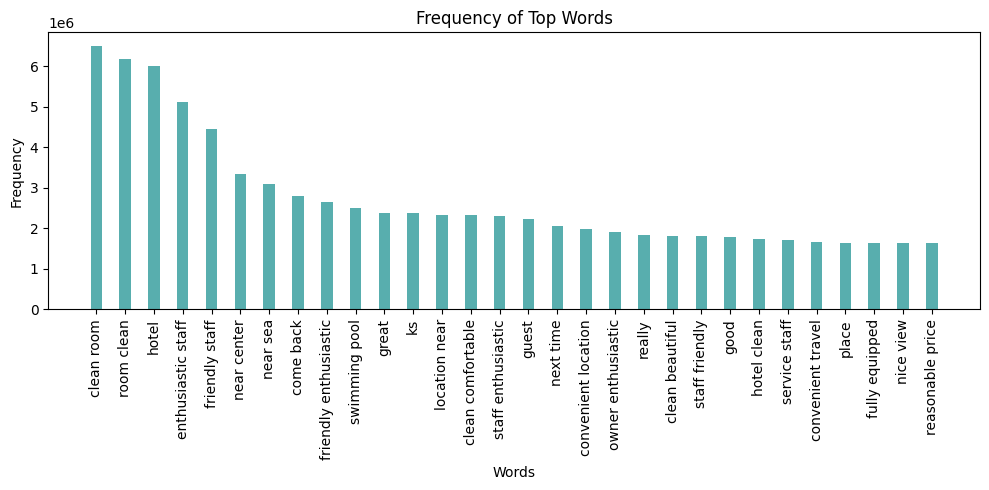

In [58]:
# creating the dataset
courses = list(data_wordcloud['Word'])
values = list(data_wordcloud['Frequency'])

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color='#58AEAE', width=0.4)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency of Top Words")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


# Positive WordCloud

In [59]:
df_pos = df_wordcloud.loc[df_wordcloud['sentiment'] == 'positive']
df_pos.head()

,comments,sentiment,label
0,good place,positive,1
2,good service staff contact nearly clock,positive,1
3,location near sea beautiful clean rooms,positive,1
4,nice room clean wide friendly friendly friendly,positive,1
5,ks near back beach room clean opportunity supp...,positive,1


In [60]:
# Loại bỏ các giá trị không phải là chuỗi từ cột 'comments'
comments_str = [str(comment) for comment in df_pos['comments'] if isinstance(comment, str)]

# Kết hợp các chuỗi lại với nhau
text = " ".join(comments_str)

# In số lượng từ trong chuỗi kết hợp
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 5288647 words in the combination of all reviews.


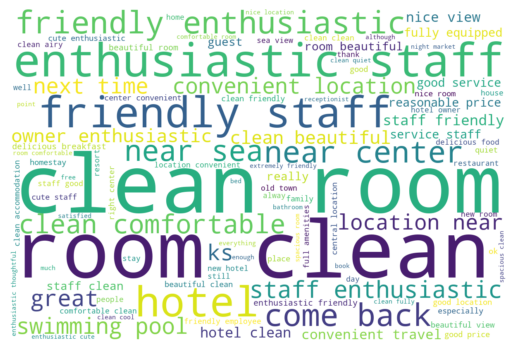

In [61]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords, max_words=100, background_color="white", colormap='viridis',).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [62]:
word_freq = wordcloud.words_

# Sắp xếp danh sách từ theo số lần xuất hiện
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# In ra những từ xuất hiện nhiều nhất
print("Top 10 words:")
words = []
frequency = []
for word, freq in sorted_word_freq[:30]:
    x=int(freq * len(text))
    print(f"{word}: {int(freq * len(text))}")
    words.append(word)  # Append word directly to the list
    frequency.append(x)  # Append freq directly to the list

Top 10 words:
clean room: 5288647
room clean: 5027965
enthusiastic staff: 4191534
friendly staff: 3632662
hotel: 3509823
friendly enthusiastic: 2184848
come back: 2183911
near center: 2084514
near sea: 1938232
clean comfortable: 1926980
staff enthusiastic: 1913852
great: 1775072
swimming pool: 1726311
ks: 1692554
convenient location: 1628790
next time: 1625039
location near: 1583780
owner enthusiastic: 1554712
clean beautiful: 1517204
staff friendly: 1506889
hotel clean: 1416869
convenient travel: 1373735
nice view: 1343728
reasonable price: 1337165
service staff: 1330601
fully equipped: 1312784
good service: 1299656
guest: 1249020
staff clean: 1227453
really: 1203073


In [63]:
print(words)
print(frequency)

['clean room', 'room clean', 'enthusiastic staff', 'friendly staff', 'hotel', 'friendly enthusiastic', 'come back', 'near center', 'near sea', 'clean comfortable', 'staff enthusiastic', 'great', 'swimming pool', 'ks', 'convenient location', 'next time', 'location near', 'owner enthusiastic', 'clean beautiful', 'staff friendly', 'hotel clean', 'convenient travel', 'nice view', 'reasonable price', 'service staff', 'fully equipped', 'good service', 'guest', 'staff clean', 'really']
[5288647, 5027965, 4191534, 3632662, 3509823, 2184848, 2183911, 2084514, 1938232, 1926980, 1913852, 1775072, 1726311, 1692554, 1628790, 1625039, 1583780, 1554712, 1517204, 1506889, 1416869, 1373735, 1343728, 1337165, 1330601, 1312784, 1299656, 1249020, 1227453, 1203073]


In [64]:
data_wordcloud_positive = pd.DataFrame({'Word': words, 'Frequency': frequency})
data_wordcloud_positive.head()

,Word,Frequency
0,clean room,5288647
1,room clean,5027965
2,enthusiastic staff,4191534
3,friendly staff,3632662
4,hotel,3509823


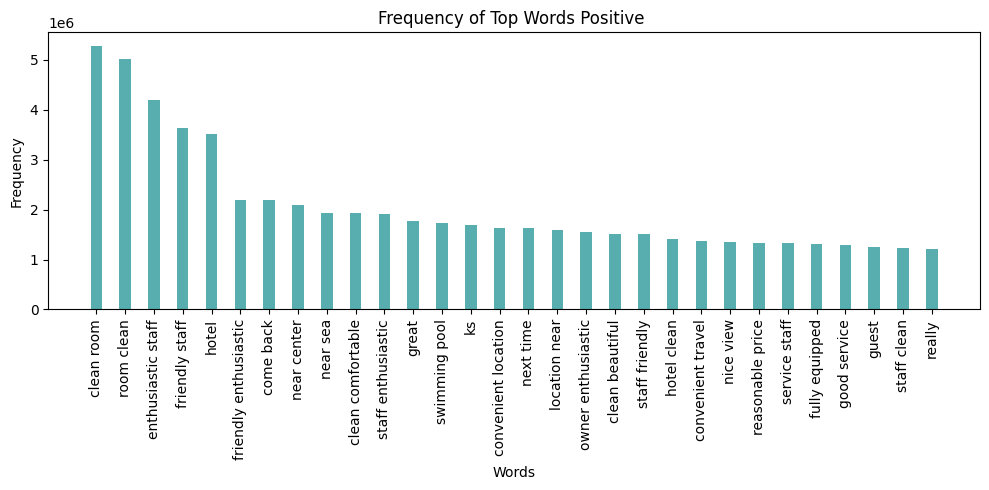

In [65]:
# creating the dataset
courses = list(data_wordcloud_positive['Word'])
values = list(data_wordcloud_positive['Frequency'])

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color='#58AEAE', width=0.4)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency of Top Words Positive ")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Negative Wordcloud

In [66]:
df_neg = df_wordcloud.loc[df_wordcloud['sentiment'] == 'negative']
df_neg.head()

,comments,sentiment,label
1,wind noisy,negative,2
42,blanket soft thin small dirty towels dirty bl...,negative,2
55,water room use downstairs heard whole night un...,negative,2
115,done day without cleaning ask reason answer af...,negative,2
127,sophistication service gentle chronic way good...,negative,2


In [67]:
# Loại bỏ các giá trị không phải là chuỗi từ cột 'comments'
comments_str = [str(comment) for comment in df_neg['comments'] if isinstance(comment, str)]

# Kết hợp các chuỗi lại với nhau
text = " ".join(comments_str)

# In số lượng từ trong chuỗi kết hợp
print ("There are {} words in the combination of all reviews.".format(len(text)))

There are 682939 words in the combination of all reviews.


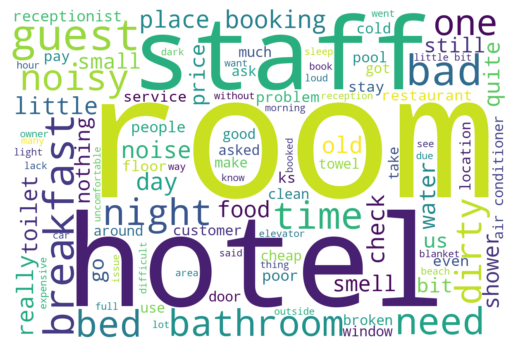

In [68]:
# Create stopword list:
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(width=1200, height=800, stopwords=stopwords, max_words=100, background_color="white", colormap='viridis',).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [69]:
word_freq = wordcloud.words_

# Sắp xếp danh sách từ theo số lần xuất hiện
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# In ra những từ xuất hiện nhiều nhất
print("Top 10 words:")
words = []
frequency = []
for word, freq in sorted_word_freq[:30]:
    x=int(freq * len(text))
    print(f"{word}: {int(freq * len(text))}")
    words.append(word)  # Append word directly to the list
    frequency.append(x)  # Append freq directly to the list

Top 10 words:
room: 682939
hotel: 315335
staff: 179342
guest: 142681
bad: 131782
breakfast: 128314
time: 106267
need: 104534
noisy: 99827
night: 98836
bed: 97845
bathroom: 97845
one: 95368
dirty: 94873
booking: 91900
little: 86946
place: 85707
day: 84469
noise: 81496
check: 80753
old: 78276
really: 78276
water: 77781
toilet: 75304
food: 75304
quite: 72331
smell: 70597
shower: 70597
small: 68615
price: 67129


In [70]:
print(words)
print(frequency)

['room', 'hotel', 'staff', 'guest', 'bad', 'breakfast', 'time', 'need', 'noisy', 'night', 'bed', 'bathroom', 'one', 'dirty', 'booking', 'little', 'place', 'day', 'noise', 'check', 'old', 'really', 'water', 'toilet', 'food', 'quite', 'smell', 'shower', 'small', 'price']
[682939, 315335, 179342, 142681, 131782, 128314, 106267, 104534, 99827, 98836, 97845, 97845, 95368, 94873, 91900, 86946, 85707, 84469, 81496, 80753, 78276, 78276, 77781, 75304, 75304, 72331, 70597, 70597, 68615, 67129]


In [71]:
data_wordcloud_negative = pd.DataFrame({'Word': words, 'Frequency': frequency})
data_wordcloud_negative.head()

,Word,Frequency
0,room,682939
1,hotel,315335
2,staff,179342
3,guest,142681
4,bad,131782


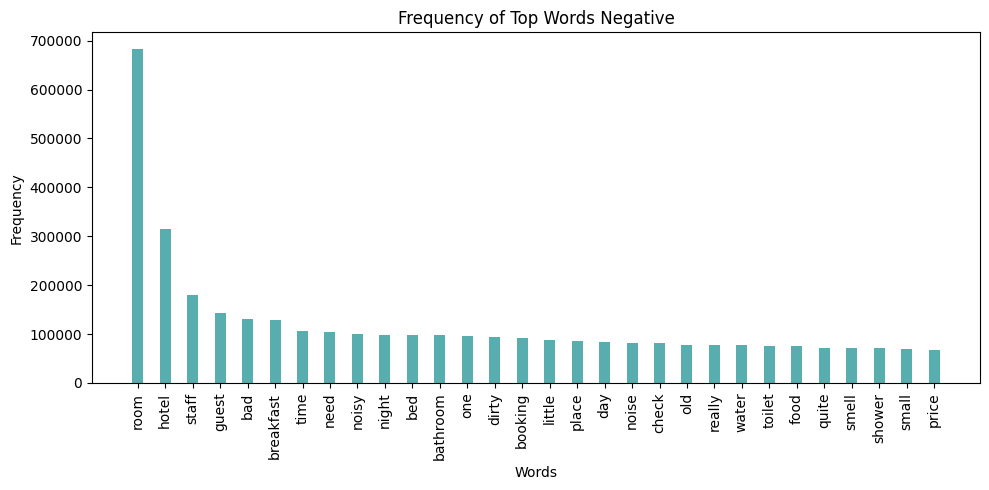

In [72]:
# creating the dataset
courses = list(data_wordcloud_negative['Word'])
values = list(data_wordcloud_negative['Frequency'])

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color='#58AEAE', width=0.4)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Frequency of Top Words Negative")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()